In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
plt.rc('axes', axisbelow=True)
V_SMALL_SIZE = 16
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=V_SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
base_path = "/mnt/container-nle-neoagdt/data/tran2015/"
samples = [3812, 3942, 3948, 3978, 3995, 4007, 4032]
scores = "analysis/evaluation/sim-specific-response-likelihoods.csv"

dfs = [pd.read_csv(base_path+str(s)+"/"+scores) for s in samples]
for s, df in zip(samples, dfs):
    df["sample"] = s
    df = df[df['population'].str.contains("1000-")]

results_df = pd.concat(dfs)
results_df = results_df.rename(columns={'sample': 'Sample ID', 'p_response': "Cell response probability"})

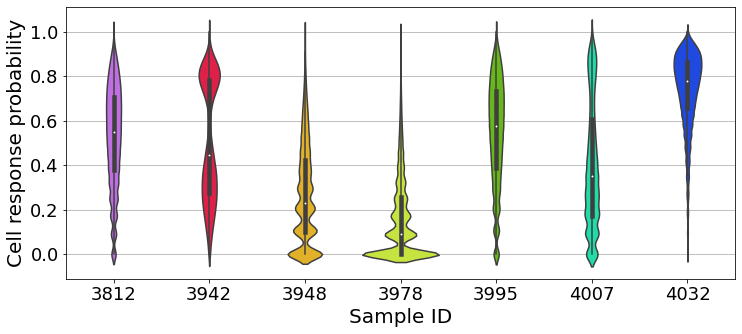

In [17]:
def create_violin_plots(df) -> None:
    """ Creates violin plots for a set of vaccines and populations.
    """
    fig, ax = plt.subplots()
    ax = sns.violinplot(
        x='Sample ID',
        y='Cell response probability',
        data=df,
        ax=ax,
        palette=sns.color_palette("gist_ncar_r", len(samples))
    )
    ax.grid(axis='y')

#     ax.legend(
#         # bbox_to_anchor=(0, 1.02, 1, 0.2),
#         # loc="lower left",
#         loc="best",
#         # mode="expand",
#         title='Vaccine optimization',
#         # ncol=len(config['final_vaccines'].keys())
#     )
#     plt.tight_layout()
#     shell_utils.ensure_path_to_file_exists(config['violin_plot_out'])
#     plt.savefig(config['violin_plot_out'], dpi=300)


plt.rcParams['figure.figsize'] = [12, 5]
create_violin_plots(results_df)
plt.savefig("figs/violin-response.pdf", dpi=300, bbox_inches = 'tight')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.05it/s]


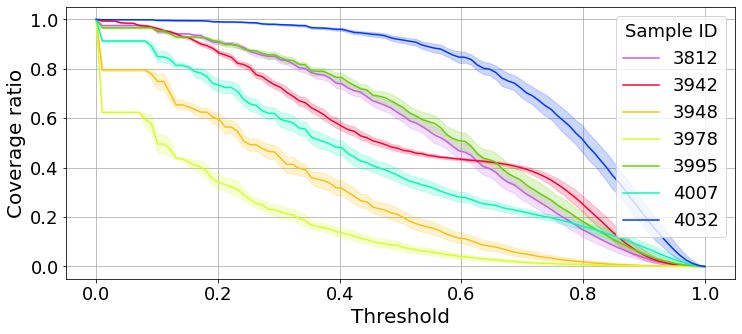

In [16]:
def _coverage_by_threshold(
        thresholds, df, v
):
    """ Compute the percentage of responding cells for different
    threshold over the response likelihood.
    """
    coverage = []
    df_vaccine = df[df['vaccine'] == v]
    for t in thresholds:
        p = len(df_vaccine[df_vaccine['Cell response probability'] > t]) / len(df_vaccine)
        coverage.append(p)
    return coverage


def plot_sim_specific_coverage_curves(
        df, samples
) -> None:
    """ Creates coverage curves (one for each combination of
    vaccine, simulation, repetition). It plots
    the percentage of population which responds to the
    simulation-specific vaccine compared to the final vaccine
    for different thresholds over the probability of response.
    """
    fig, ax = plt.subplots()

    thresholds = np.linspace(0, 1, num=100)
    
    results = []
    for s in tqdm(samples):
        temp_df = df[df["Sample ID"] == s]
        sim_specific_vaccines = temp_df['vaccine'].unique().tolist()

        for s_s_v in sim_specific_vaccines:
            vaccine_coverage_map = {'Threshold': [], 'Coverage ratio': []}

            vaccine_coverage_map['Coverage ratio'] += _coverage_by_threshold(
                thresholds, temp_df, s_s_v
            )
            vaccine_coverage_map['Threshold'] += thresholds.tolist()

            df_sim_specific = pd.DataFrame(vaccine_coverage_map)
            df_sim_specific['Sample ID'] = s
            df_sim_specific['vaccine'] = s_s_v
            results.append(df_sim_specific)
            
    ax = sns.lineplot(
        data=pd.concat(results).reset_index(drop=True),
        x='Threshold',
        y='Coverage ratio',
        hue="Sample ID",
        palette=sns.color_palette("gist_ncar_r", len(samples))
    )
    plt.rc('axes', axisbelow=True)
    ax.grid(axis='y')
    ax.grid(axis='x')
plot_sim_specific_coverage_curves(results_df, samples)
plt.savefig("figs/coverage.pdf", dpi=300, bbox_inches = 'tight')

In [4]:
plt.rcParams['figure.figsize'] = [12, 5]

base_path = "/mnt/container-nle-neoagdt/data/tran2015/"
samples = [3812, 3942, 3948, 3978, 3995, 4007, 4032]
# samples = [3812, 3942, 3948, 3978, 3995, 4007]
scores = "analysis-multi/vaccines/selected-vaccine-elements.budget-10.minsum.adaptive.csv"

dfs = [pd.read_csv(base_path+str(s)+"/"+scores) for s in samples]
for s, df in zip(samples, dfs):
    df["sample"] = s
    df['pop_size'] = df['simulation_name'].apply(lambda x: x.split('-')[0])

results_df = pd.concat(dfs).reset_index(drop=True)
results_df = results_df.astype({'pop_size': 'int32'})
pop_sizes = results_df['pop_size'].unique()

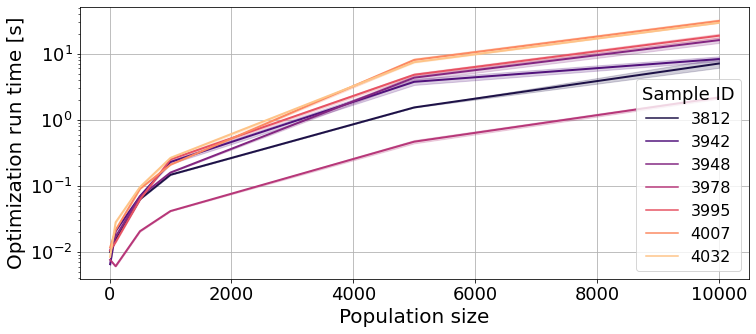

In [5]:
ax = sns.lineplot(
        data=results_df.rename(columns={'pop_size': 'Population size', 'run_time': 'Optimization run time [s]', 'sample': 'Sample ID'}),
        x='Population size',
        y='Optimization run time [s]',
        hue="Sample ID",
        linewidth=2,
        palette=sns.color_palette("magma", len(samples))
    )
plt.rc('axes', axisbelow=True)
ax.grid(axis='y')
ax.grid(axis='x')
plt.yscale('log')
plt.savefig("figs/run-time.pdf", dpi=300, bbox_inches = 'tight')

In [6]:
s_list = []
pop_size_list = []
iou_list = []

for p in pop_sizes:
    for s in samples:
        temp = results_df[results_df['sample']==s]
        temp = temp[temp['pop_size']==p]
        vaccines = []
        for r in temp['repetition'].unique():
            temp_r = temp[temp['repetition'] == r]
            vaccines.append(set(temp_r.peptide))
        s_list.append(s)
        pop_size_list.append(p)
        iou_list.append(len(set.intersection(*vaccines)) / len(set.union(*vaccines)))
            
iou_df = pd.DataFrame(data={'Vaccines IoU': iou_list, 'Population size': pop_size_list, 'Sample ID': s_list})

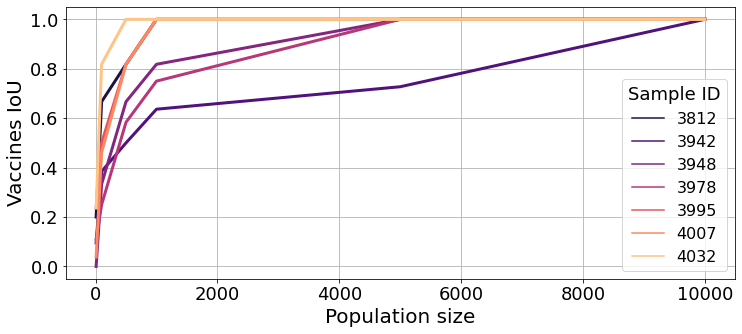

In [7]:
ax = sns.lineplot(
        data=iou_df,
        x='Population size',
        y='Vaccines IoU',
        hue="Sample ID",
        linewidth=3,
        palette=sns.color_palette("magma", len(samples))
    )
plt.rc('axes', axisbelow=True)
ax.grid(axis='y')
ax.grid(axis='x')
plt.savefig("figs/iou.pdf", dpi=300, bbox_inches = 'tight')
